<a href="https://colab.research.google.com/github/pavansai26/credit-card-fraud-detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing the necessary libraries


In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


In [2]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018


In [3]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [4]:
import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

ignoring the warnings


In [5]:
import warnings
warnings.filterwarnings('ignore',category = DeprecationWarning)
warnings.filterwarnings('ignore',category = UserWarning)
warnings.filterwarnings('ignore',category = RuntimeWarning)
warnings.filterwarnings('ignore',category = FutureWarning)

setting the no.of rows and columns


In [6]:
pd.set_option('display.max_rows',100000)
pd.set_option('display.max_columns',1000)

accessing the drive


In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Reading the Data


In [8]:
data_df = pd.read_csv('/gdrive/My Drive/creditcard.csv')


Check the data

In [9]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


Glimpse the data

We start by looking to the data features (first 5 rows).

In [10]:
data_df.head()


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

Let's look into more details to the data.



In [11]:
data_df.describe()


Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

                V10           V11           V12           V13           V14  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.239053e-15  1.673327e-15 -1.247012e-15  8.190001e-16  1.207294e-15   
std    1.088850e+00  1.020713e+00  9.992014e-01  9.952742e-01  9.585956e-01   
min   -2.458826e+01 -4.797473e+00 -1.868371e+01 -5.791881e+00 -1.921433e+01   
25%   -5.354257e-01 -7.624942e-01 -4.055715e-01 -6.485393e-01 -4.255740e-01   
50%   -9.291738e-02 -3.275735e-02  1.400326e-01 -1.356806e-02  5.060132e-02   
75%    4.539234e-01  7.395934e-01  6.182380e-01  6.625050e-01  4.931498e-01   
max    2.374514e+01  1.201891e+01  7.848392e+00  7.126883e+00  1.052677e+01   

                V15           V16           V17           V18           V19  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   4.887456e-15  1.437716e-15 -3.772171e-16  9.564149e-16  1.039917e-15   
std    9.153160e-01  8.762529e-01  8.493371e-01  8.381762e-01  8.140405e-01   
min   -4.498945e+00 -1.412985e+01 -2.516280e+01 -9.498746e+00 -7.213527e+00   
25%   -5.828843e-01 -4.680368e-01 -4.837483e-01 -4.988498e-01 -4.562989e-01   
50%    4.807155e-02  6.641332e-02 -6.567575e-02 -3.636312e-03  3.734823e-03   
75%    6.488208e-01  5.232963e-01  3.996750e-01  5.008067e-01  4.589494e-01   
max    8.877742e+00  1.731511e+01  9.253526e+00  5.041069e+00  5.591971e+00   

                V20           V21           V22           V23           V24  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   6.406204e-16  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    7.709250e-01  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min   -5.449772e+01 -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%   -2.117214e-01 -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%   -6.248109e-02 -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    1.330408e-01  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    3.942090e+01  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02

Looking to the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

Check missing data

Let's check if there is any missing data.



In [12]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

Time  V16  Amount  V28  V27  V26  V25  V24  V23  V22  V21  V20  V19  \
Total     0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Percent   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

         V18  V17  V15   V1  V14  V13  V12  V11  V10   V9   V8   V7   V6   V5  \
Total    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Percent  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

          V4   V3   V2  Class  
Total    0.0  0.0  0.0    0.0  
Percent  0.0  0.0  0.0    0.0

There is no missing data in the entire dataset.



Data unbalance

Let's check data unbalance with respect with target value, i.e. Class.



In [13]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

This code first computes the class distribution by counting the occurrences of each class (0 and 1) in the "Class" column of the "data_df" DataFrame. It then creates a DataFrame called "df" to store the class labels and their corresponding counts.

Next, a Bar trace is created using the go.Bar function from Plotly. The x-values are the class labels from the "Class" column of the DataFrame, and the y-values are the counts from the "values" column. The trace is also given a name, a red color, and the text parameter is set to display the count values.

The trace is then added to a list called "data". The layout information, including the plot title, x-axis and y-axis labels, hover mode, and width, is stored in the "layout" dictionary.

Finally, a dictionary called "fig" is created to combine the data and layout information. The iplot function is called to display the bar plot using the specified layout and data.

This code will generate an interactive bar plot showing the number of transactions for each class label, with the title and axis labels provided.

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

Data exploration

In [14]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Credit Card Transactions Time Density Plot

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [15]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

Hour  Class   Min      Max  Transactions        Sum        Mean   Median  \
0   0.0      0   0.0  7712.43          3961  256572.87   64.774772   12.990   
1   0.0      1   0.0   529.00             2     529.00  264.500000  264.500   
2   1.0      0   0.0  1769.69          2215  145806.76   65.826980   22.820   
3   1.0      1  59.0   239.93             2     298.93  149.465000  149.465   
4   2.0      0   0.0  4002.88          1555  106989.39   68.803466   17.900   

             Var  
0   45615.821201  
1  139920.500000  
2   20053.615770  
3   16367.832450  
4   45355.430437

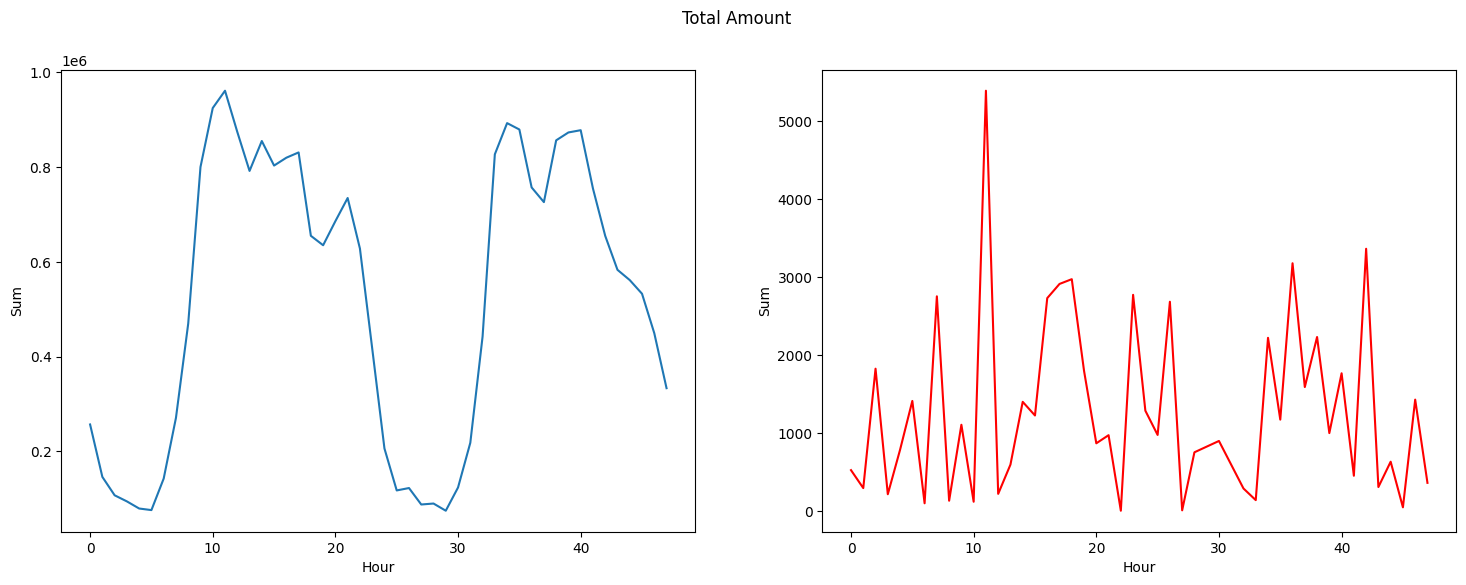

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

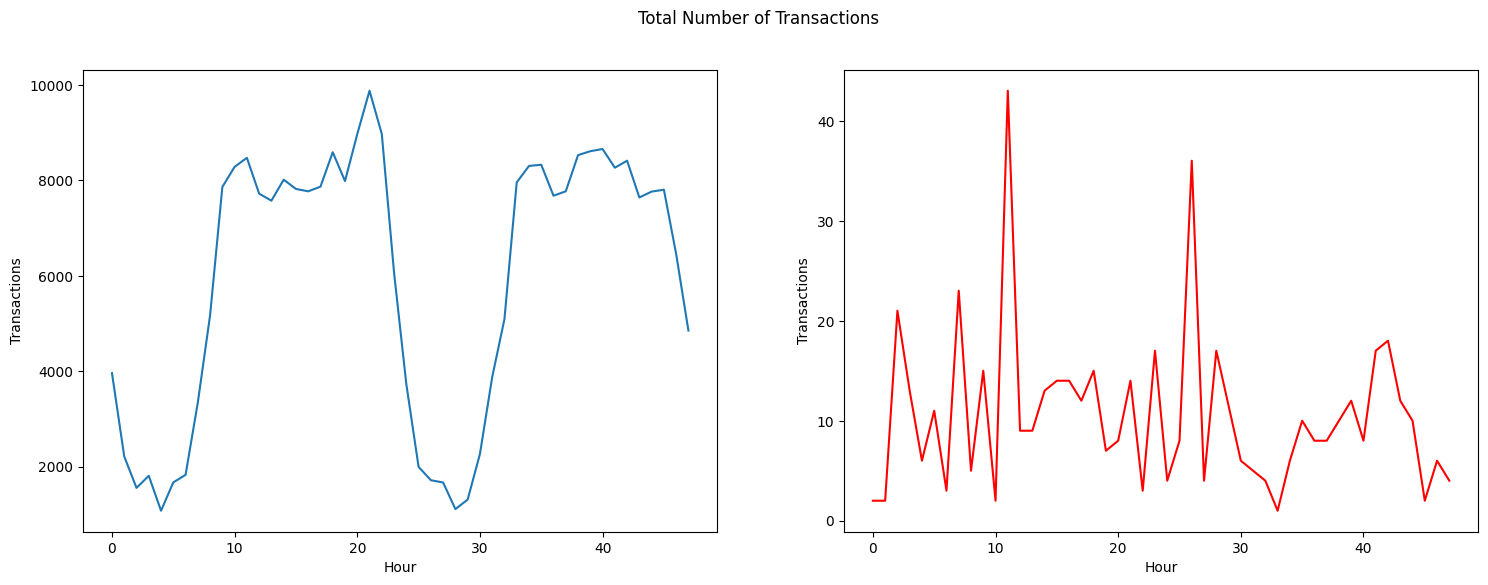

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

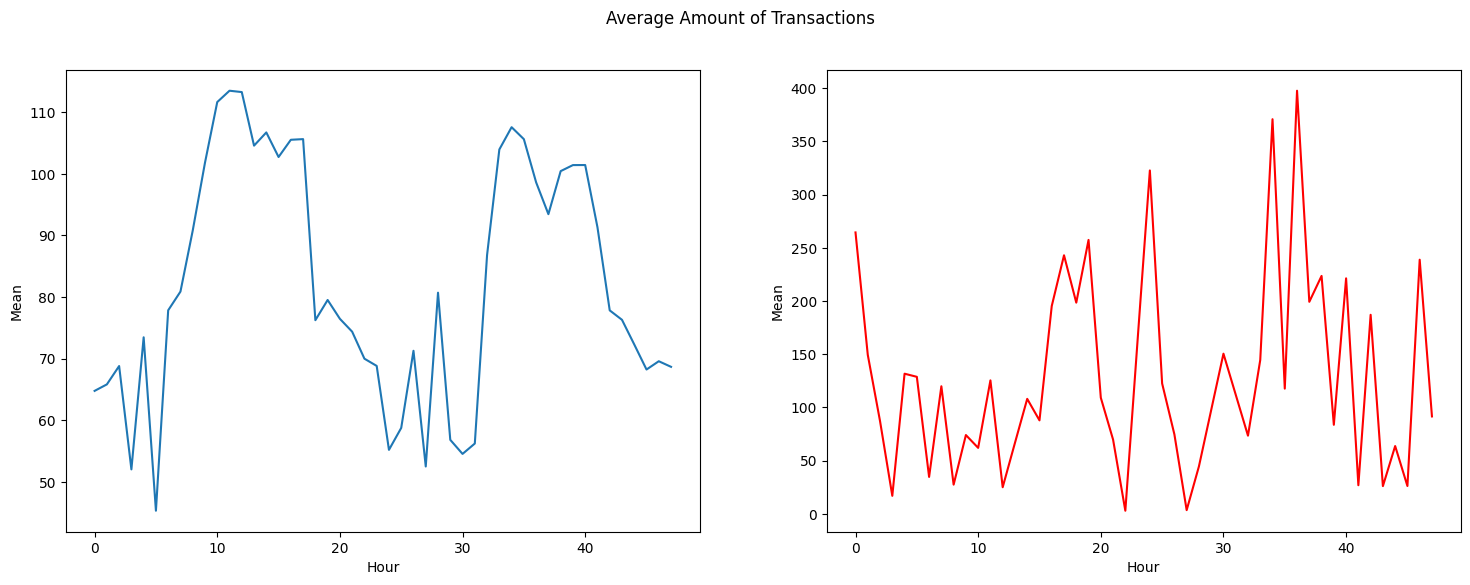

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

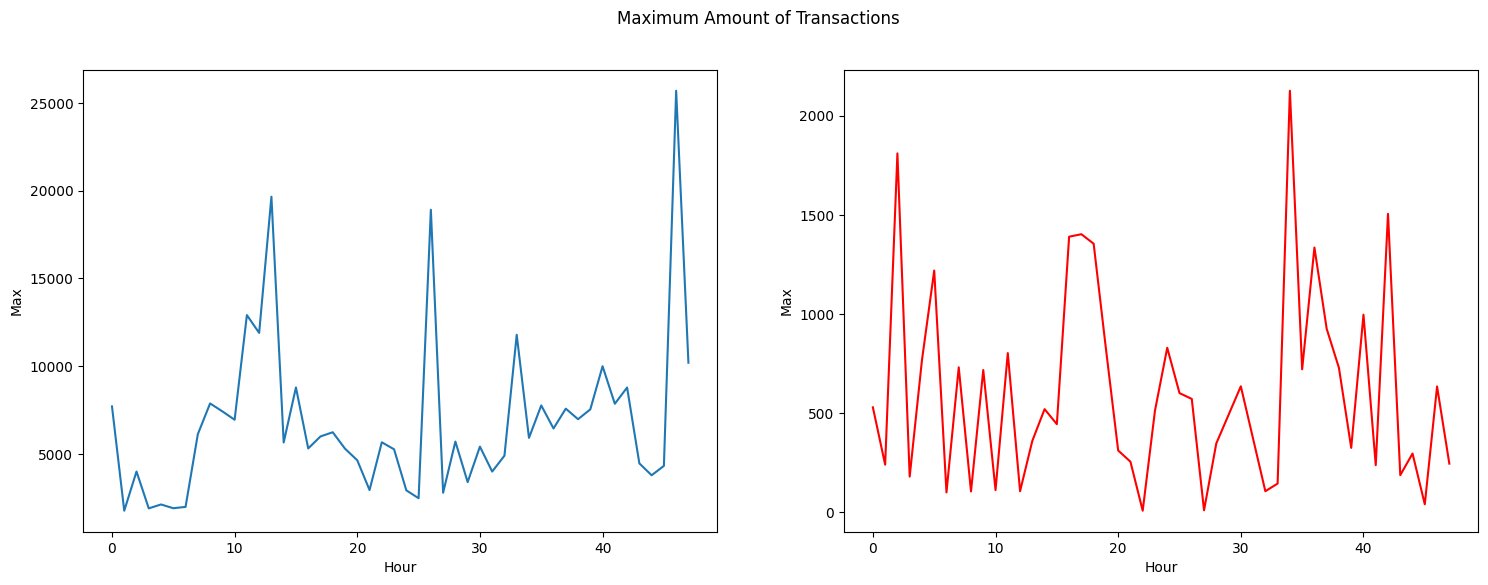

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

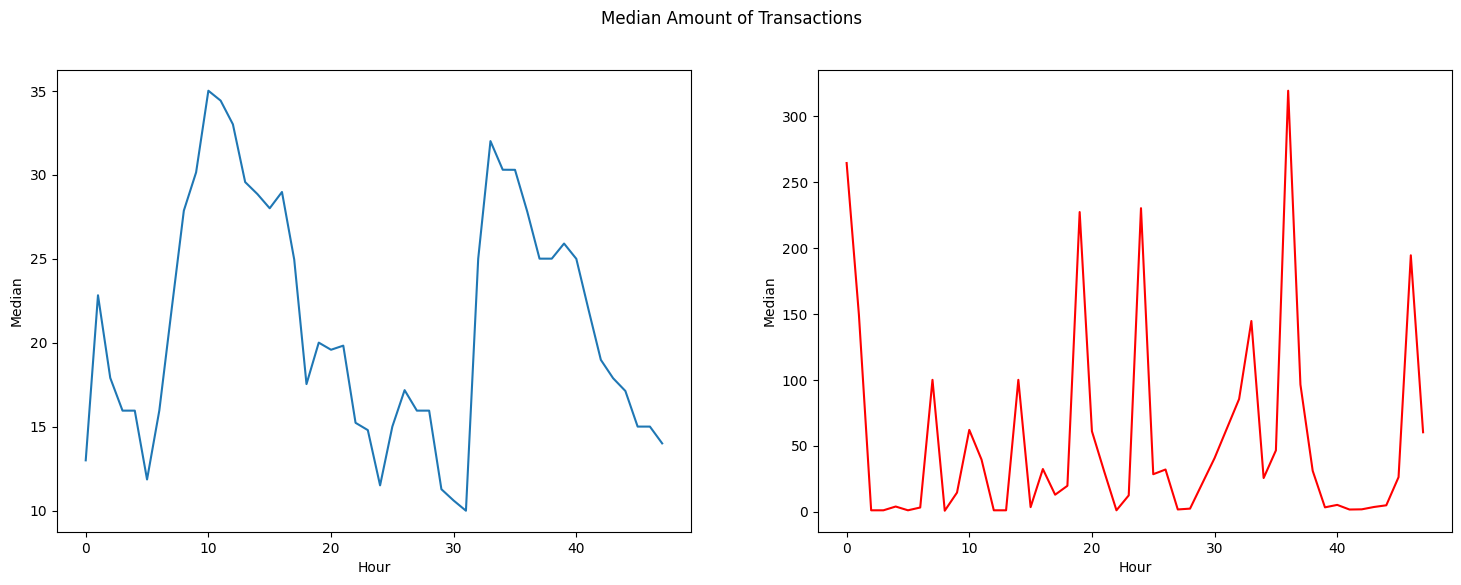

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

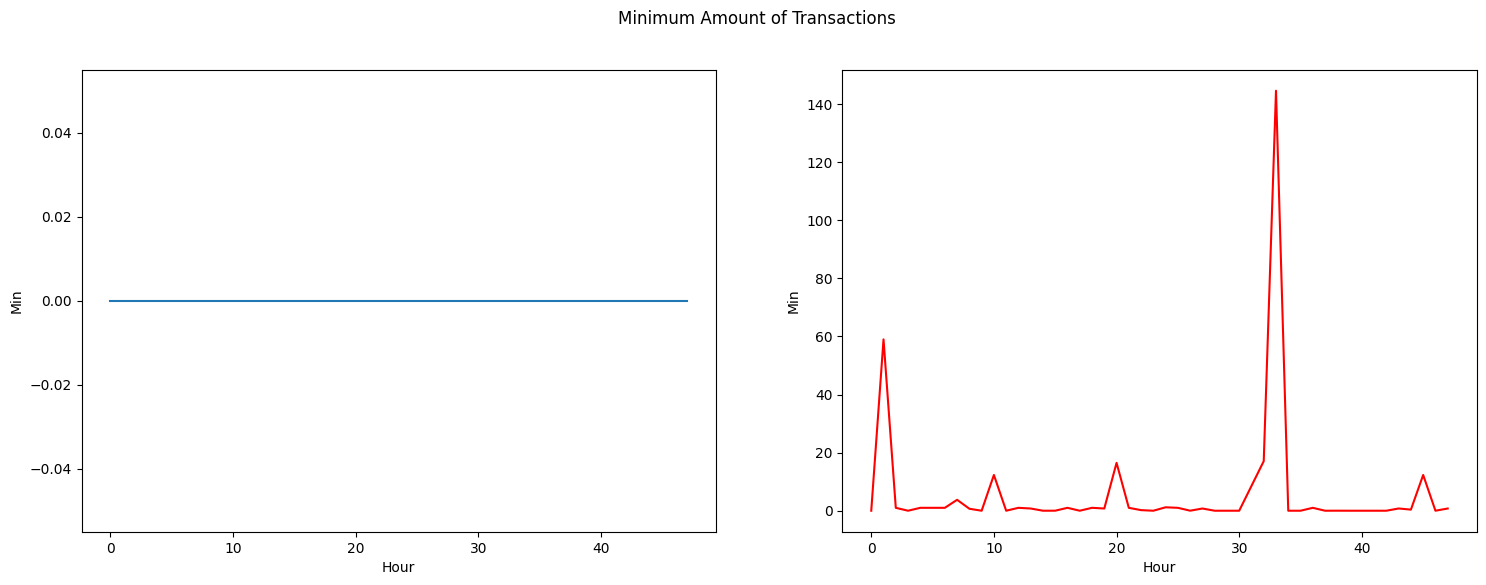

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();


Transactions amount

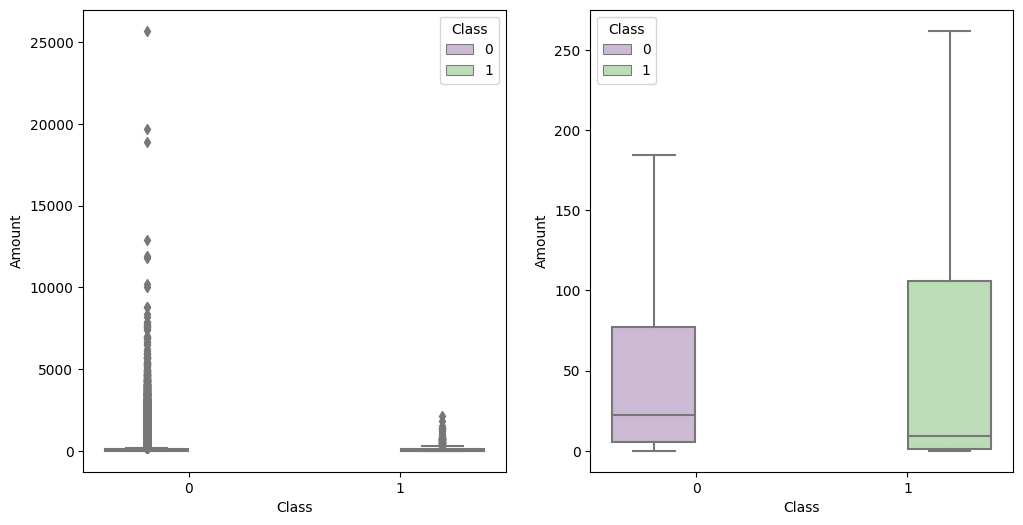

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [23]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [24]:
class_1.describe()


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [25]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

This code is using the Plotly library to create a scatter plot of the "Time" and "Amount" variables for fraudulent transactions in the "data_df" DataFrame.

First, the code creates a subset of the data where the "Class" column is equal to 1, which corresponds to fraudulent transactions.

Then, the code creates a Plotly Scatter object with the "Time" column on the x-axis and the "Amount" column on the y-axis. The "name" parameter is set to "Amount", which will be used in the plot legend. The "marker" parameter is used to specify the color, line width, and opacity of the scatter plot points. The "text" parameter is used to specify the text that appears when hovering over a data point with the mouse. The "mode" parameter is set to "markers", which indicates that the plot will display individual data points.

Next, the code creates a list containing the Scatter object, and a dictionary containing layout information such as the plot title, x-axis and y-axis titles, and hover mode.

Finally, the code calls the "iplot" function from Plotly to display the plot in the Jupyter notebook. The plot will be interactive, allowing the user to zoom in and out, pan, and hover over data points to view their values.

Overall, this code is useful for visualizing the distribution of fraudulent transaction amounts over time, which can help identify any patterns or trends in the data. 

amount of fraudulent transactions

Features correlation

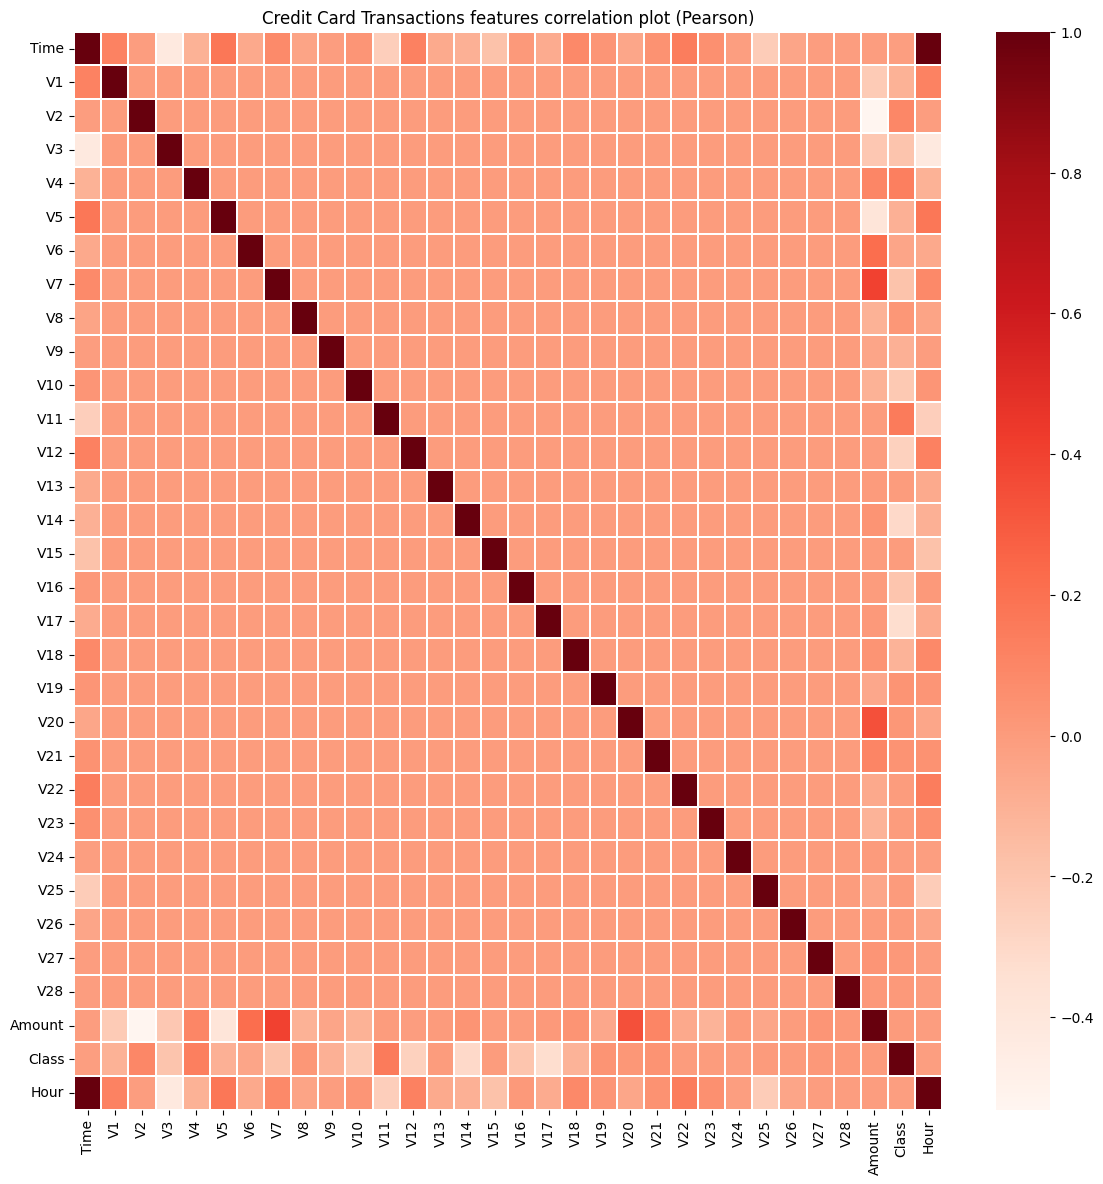

In [26]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

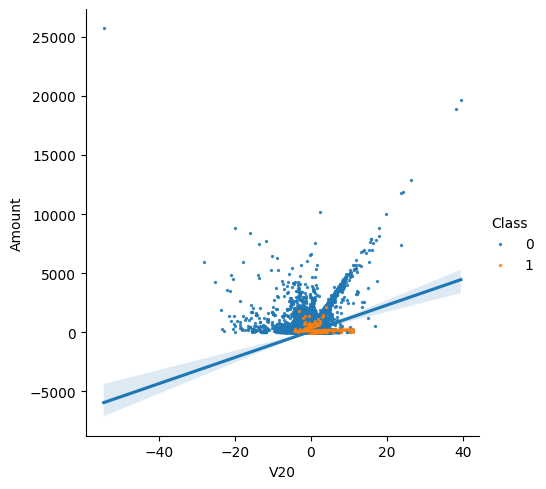

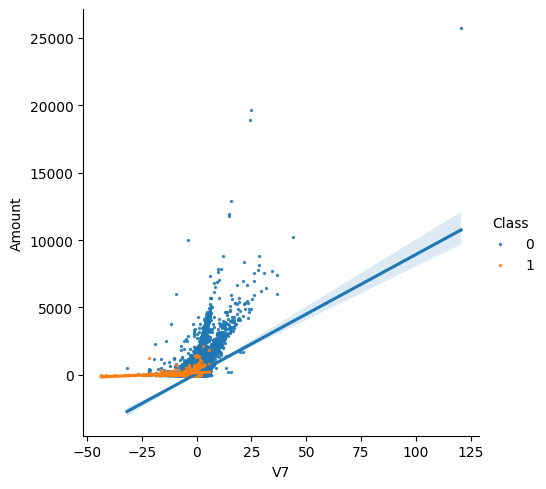

In [27]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

This code is using the seaborn library to create two scatter plots with a linear regression line (or "trendline") overlaid on top of the data. The code uses the "lmplot" function from seaborn, which creates a FacetGrid with a linear regression line and confidence interval plotted on top of each subset of the data, defined by the "hue" parameter.

The first scatter plot displays the relationship between the "V20" and "Amount" variables in the "data_df" DataFrame. The "hue" parameter is set to "Class", which indicates that the scatter plot points will be colored according to the "Class" column in the DataFrame (i.e., 0 for non-fraudulent transactions and 1 for fraudulent transactions). The "fit_reg" parameter is set to True, which indicates that a linear regression line should be fitted to the data. The "scatter_kws" parameter is used to adjust the size of the scatter plot points.

The second scatter plot displays the relationship between the "V7" and "Amount" variables in the "data_df" DataFrame, with similar parameters to the first scatter plot.

Finally, the code displays the two scatter plots using the "plt.show()" function from matplotlib.

Overall, this code is useful for visualizing the relationship between two continuous variables in a dataset and how it differs between two classes. The scatter plots with regression lines can help identify any patterns or trends in the data, which can be useful for understanding the data and selecting features for a machine learning model.

Let's plot now the inverse correlated values.

We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).



Features density plot


<Figure size 640x480 with 0 Axes>

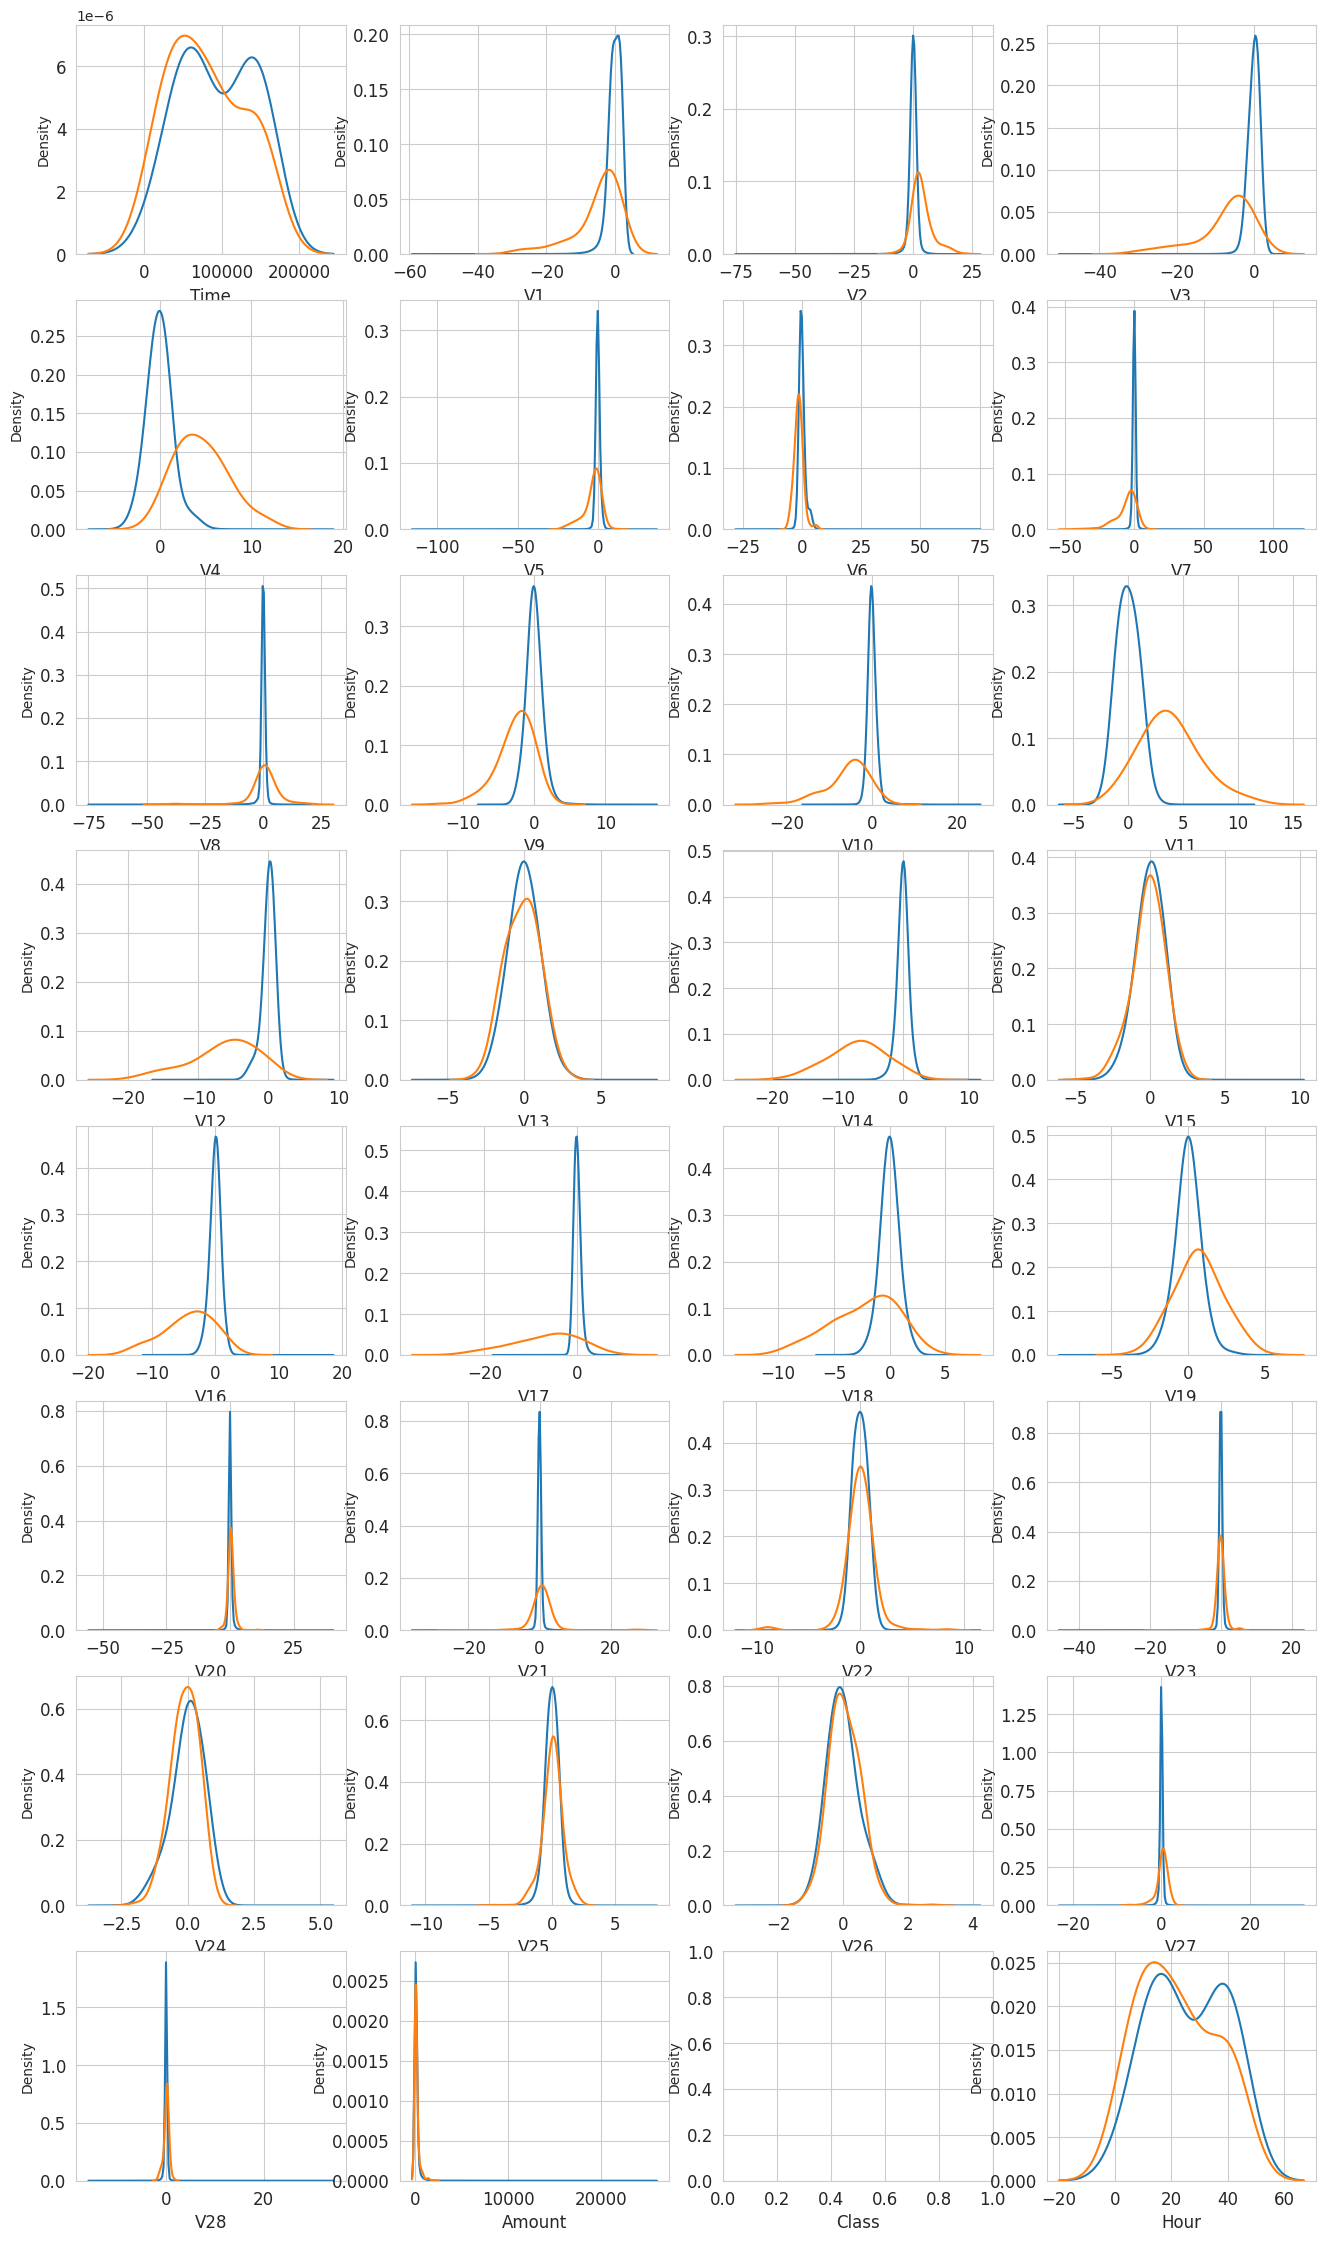

In [28]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

The code first defines a variable "var" that contains an array of the column names for the features in the dataset.

Next, the code creates two separate datasets "t0" and "t1" based on the "Class" column of the original dataset. The "t0" dataset contains all rows where the "Class" value is 0, while the "t1" dataset contains all rows where the "Class" value is 1.

The code then sets the seaborn style to 'whitegrid', creates a new figure and axis object using the "subplots" method from matplotlib, and sets the figure size to (16,28).

The code then loops through each feature in "var" and creates a new subplot using the "subplot" method from matplotlib. Within each subplot, the code creates two overlaid kernel density estimation (KDE) plots using the "kdeplot" method from seaborn, one for each class value. The "bw" parameter sets the bandwidth of the KDE plots. The code also adds a label for each class value.

Finally, the code sets the x-axis label to the feature name, sets the tick label size, and displays the plot.

Overall, this code is useful for visualizing the distribution of each feature in a dataset and how it differs between two classes. The density plots can help identify any differences or similarities in the distribution of features between the two classes, which can be useful for understanding the data and selecting features for a machine learning model.

For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.

Predictive models

Define predictors and target values
Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [29]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

Split data in train, test and validation set
Let's define train, validation and test sets.

In [30]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

RandomForestClassifier
Define model parameters
Let's set the parameters for the model.





We start by initializing the RandomForestClassifier.



In [31]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the RandonForestClassifier using the train_df data and fit function.



In [32]:
clf.fit(train_df[predictors], train_df[target].values)


RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the target values for the valid_df data, using predict function.



In [33]:
preds = clf.predict(valid_df[predictors])


Let's also visualize the features importance.



Features importance

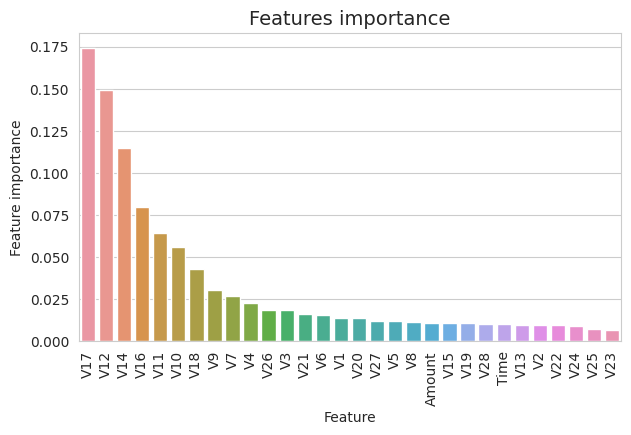

In [34]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

This code is creating a bar plot to display the importance of different features in a machine learning model. The code first creates a pandas DataFrame called "tmp" with two columns: "Feature" and "Feature importance". The "Feature" column contains a list of the names of the predictor variables used in the model, and the "Feature importance" column contains the corresponding importance values for each feature.

The code then sorts the DataFrame in descending order based on the "Feature importance" column using the "sort_values" method.

Next, the code creates a bar plot using the seaborn library. The x-axis of the plot displays the names of the predictor variables (the "Feature" column), and the y-axis displays the corresponding importance values (the "Feature importance" column). The bars are sorted in descending order based on the feature importance values.

Finally, the code uses various functions from the matplotlib library to customize the plot, including setting the figure size, adding a title, rotating the x-axis labels, and displaying the plot.

The most important features are V17, V12, V14, V10, V11, V16.



Confusion matrix
Let's show a confusion matrix for the results we obtained.

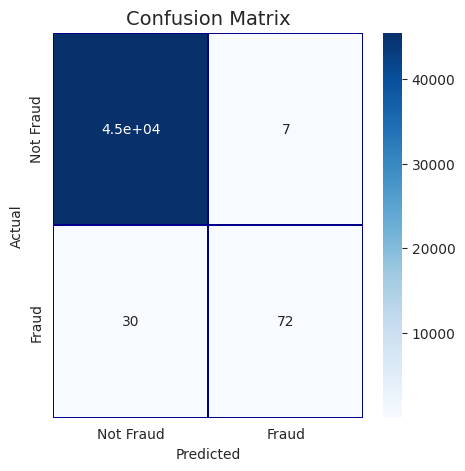

In [35]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Area under curve

In [36]:
roc_auc_score(valid_df[target].values, preds)


0.8528641975628091